In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
%matplotlib inline

# 2.0 Data Clean Up

The scraped data needs some cleanup, mainly updating indexes and createing some columns

In [507]:
playerdf = pd.read_pickle('data/playerdataraw.pkl')
advstatsdf = pd.read_pickle('data/advstatsdataraw.pkl')
colstatsdf = pd.read_pickle('data/colstatsdataraw.pkl')

In [508]:
playerdf = playerdf.reset_index(drop=True)
advstatsdf = advstatsdf.reset_index(drop=False)
colstatsdf = colstatsdf.reset_index(drop=False)

In [509]:
playerdf.shape

(2196, 7)

In [510]:
advstatsdf = advstatsdf.rename(columns={'index': 'year'})
advstatsdf['year'] = advstatsdf['year'] + 1

In [529]:
advstatsdf.head()

,year,3PAr,AST%,Age,BLK%,BPM,DBPM,DRB%,DWS,FTr,...,Season,TOV%,TRB%,TS%,Tm,USG%,VORP,WS,WS/48,player
0,1,0.000,13.1,19.0,1.1,-9.8,-1.2,8.2,0.1,0.444,...,2017-18,15.7,6.4,0.372,PHI,21.4,-0.1,-0.1,-0.082,Markelle Fultz
1,1,0.489,28.9,20.0,2.1,0.9,2.4,18.3,1.7,0.125,...,2017-18,18.9,11.2,0.436,LAL,17.9,0.9,1.0,0.040,Lonzo Ball
2,1,0.322,6.7,19.0,2.2,1.6,1.8,16.3,2.7,0.369,...,2017-18,10.8,9.7,0.610,BOS,18.0,1.4,5.2,0.163,Jayson Tatum
3,1,0.272,8.9,20.0,1.1,-5.1,-1.5,13.2,0.6,0.324,...,2017-18,13.2,9.0,0.466,PHO,24.1,-0.8,-0.6,-0.029,Josh Jackson
4,1,0.167,24.8,20.0,0.9,-5.1,-1.8,9.6,0.4,0.255,...,2017-18,17.5,5.6,0.469,SAC,22.9,-0.9,-0.7,-0.030,De'Aaron Fox


In [511]:
colstatsdf = colstatsdf.rename(columns={'index': 'year'})
colstatsdf['year'] = colstatsdf['year'] + 1

In [512]:
colstatsdf.columns.values[23] = 'avgMP'
colstatsdf.columns.values[24] = 'avgPTS'
colstatsdf.columns.values[25] = 'avgTRB'
colstatsdf.columns.values[26] = 'avgAST'
colstatsdf['FG%'] = pd.to_numeric(colstatsdf['FG%'])
colstatsdf['3P%'] = pd.to_numeric(colstatsdf['3P%'])
colstatsdf['avgPTS'] = pd.to_numeric(colstatsdf['avgPTS'])
colstatsdf['avgMP'] = pd.to_numeric(colstatsdf['avgMP'])
colstatsdf['avgTRB'] = pd.to_numeric(colstatsdf['avgTRB'])
colstatsdf['avgAST'] = pd.to_numeric(colstatsdf['avgAST'])

In [513]:
carcoldffull = colstatsdf[colstatsdf['Season']=='Career']
carcoldf = carcoldffull[['name','FG%','3P%','avgPTS','avgMP','avgTRB','avgAST']]
carcoldf.dtypes

0
name       object
FG%       float64
3P%       float64
avgPTS    float64
avgMP     float64
avgTRB    float64
avgAST    float64
dtype: object

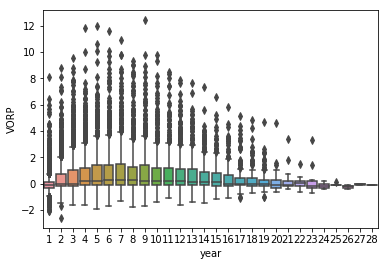

In [514]:
sns.boxplot(x="year", y="VORP", data=advstatsdf);

## 2.1 Combining Data sets into a model

Once the data is cleaned, we then can make one model data set

First we need to do some group bys to get Postion, VORP and Age

In [515]:
playeravgvorp = advstatsdf.groupby(['player'],as_index=False)[['VORP']].mean()
playeravgvorp = playeravgvorp.rename(columns = {'VORP':'avgVORP'})
playeravgvorp.sort_values('avgVORP',ascending=False).head(10)

,player,avgVORP
1229,LeBron James,8.060000
1387,Michael Jordan,6.966667
1208,Larry Bird,6.123077
1281,Magic Johnson,5.953846
279,Charles Barkley,5.843750
475,David Robinson,5.778571
321,Chris Paul,5.700000
1090,Karl Malone,5.400000
1723,Russell Westbrook,5.320000
853,James Harden,5.111111


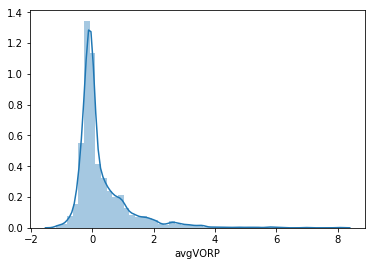

In [516]:
sns.distplot(playeravgvorp.avgVORP, hist=True, kde=True);

In [517]:
playerstartage = advstatsdf.groupby(['player'],as_index = False)[['Age']].min()
playerpos = advstatsdf.groupby(['player','Pos'],as_index = False)['year'].count()
playerpos['count_max'] = playerpos.groupby(['player'])['year'].transform(max)
playerpos = playerpos[playerpos['year'] == playerpos['count_max']]
playerpos = playerpos[['player','Pos']]

Next we can merge the grouped data points into on data set, called Playerdatafull

In [518]:
playerdatafull = pd.merge(playerdf,playeravgvorp,how='inner')
playerdatafull = pd.merge(playerdatafull,playerstartage,how='inner')
playerdatafull = pd.merge(playerdatafull,playerpos,how='inner')
playerdatafull = pd.merge(playerdatafull,carcoldf,how='left',left_on='player',right_on='name')
playerdatafull.sort_values('avgVORP',ascending=False).shape

(2199, 17)

In [519]:
playerdatafull = playerdatafull[playerdatafull['draftnbr']<31]
playerdatafull = playerdatafull[playerdatafull['draftyr']<2013]
playerdatafull = playerdatafull.drop_duplicates(subset='player',keep=False)
playerdatafull.head()

,player,height,weight,draftnbr,draftyr,recruitnbr,urlx,avgVORP,Age,Pos,name,FG%,3P%,avgPTS,avgMP,avgTRB,avgAST
260,Anthony Davis,6.833333,253,1,2012,1,/players/d/davisan02.html,3.400000,19.0,PF,Anthony Davis,0.623,0.150,14.2,32.0,10.4,1.3
261,Michael Kidd-Gilchrist,6.583333,232,2,2012,3,/players/k/kiddgmi01.html,0.433333,19.0,SF,Michael Kidd-Gilchrist,0.491,0.255,11.9,31.1,7.4,1.9
262,Bradley Beal,6.416667,207,3,2012,4,/players/b/bealbr01.html,1.316667,19.0,SG,Bradley Beal,0.445,0.339,14.8,34.2,6.7,2.2
263,Dion Waiters,6.333333,225,4,2012,31,/players/w/waitedi01.html,-0.312500,21.0,SG,Dion Waiters,0.453,0.348,9.7,20.4,1.9,2.0
264,Thomas Robinson,6.833333,237,5,2012,28,/players/r/robinth01.html,-0.244444,21.0,PF,Thomas Robinson,0.525,0.500,9.8,18.7,7.3,1.0


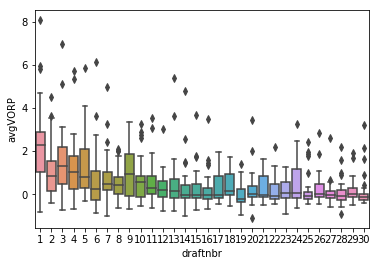

In [520]:
sns.boxplot(x="draftnbr", y="avgVORP", data=playerdatafull);

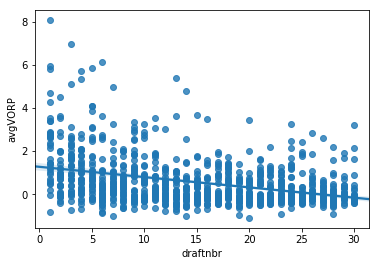

In [521]:
sns.regplot(x="draftnbr", y="avgVORP", data=playerdatafull);

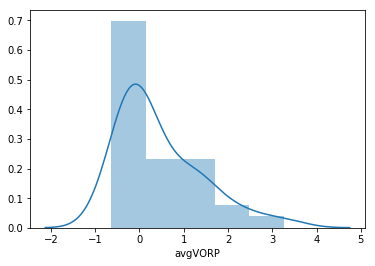

In [528]:
firstpickdraftvorpavg = playerdatafull[playerdatafull['draftnbr']==24]
sns.distplot(firstpickdraftvorpavg.avgVORP, hist=True, kde=True);

## 2.2 Then we clean up missing data

A lot of players had missing college records so we filled them with the avg

In [523]:
modeldatafull = playerdatafull[['draftnbr','Age','height','FG%','3P%','avgPTS','avgMP','avgTRB','avgAST','avgVORP']]
#modeldata = pd.get_dummies(modeldata, drop_first = True)
modeldatafull.isnull().sum()

draftnbr      0
Age           0
height        0
FG%         101
3P%         399
avgPTS      101
avgMP       177
avgTRB      101
avgAST      267
avgVORP       0
dtype: int64

In [524]:
meandatadf = modeldata.mean()
modeldata = modeldatafull.apply(lambda x: x.fillna(x.mean()),axis=0)
modeldata.head()

,draftnbr,Age,height,FG%,3P%,avgPTS,avgMP,avgTRB,avgAST,avgVORP
260,1,19.0,6.833333,0.623,0.150,14.2,32.0,10.4,1.3,3.400000
261,2,19.0,6.583333,0.491,0.255,11.9,31.1,7.4,1.9,0.433333
262,3,19.0,6.416667,0.445,0.339,14.8,34.2,6.7,2.2,1.316667
263,4,21.0,6.333333,0.453,0.348,9.7,20.4,1.9,2.0,-0.312500
264,5,21.0,6.833333,0.525,0.500,9.8,18.7,7.3,1.0,-0.244444


## 2.3 Correlations and Pair Plot
Once we have all of the features updated, then we can look at the correlations and pair plots

Overall there are not really many strong correlations, especially considering avgVORP

In [525]:
modeldata.corr()

,draftnbr,Age,height,FG%,3P%,avgPTS,avgMP,avgTRB,avgAST,avgVORP
draftnbr,1.000000,0.292028,-0.092186,-0.154647,-0.068696,-0.232967,-0.128728,-0.185212,-0.056676,-0.368640
Age,0.292028,1.000000,-0.045807,0.118771,0.051530,-0.035047,-0.042335,-0.008746,-0.033342,-0.216046
height,-0.092186,-0.045807,1.000000,0.492166,-0.209201,-0.200824,-0.334328,0.575853,-0.632537,-0.008218
FG%,-0.154647,0.118771,0.492166,1.000000,-0.160686,-0.043192,-0.225970,0.482510,-0.447735,0.100795
3P%,-0.068696,0.051530,-0.209201,-0.160686,1.000000,0.135588,0.154214,-0.177176,0.212047,0.096097
avgPTS,-0.232967,-0.035047,-0.200824,-0.043192,0.135588,1.000000,0.634881,0.275686,0.154072,0.120581
avgMP,-0.128728,-0.042335,-0.334328,-0.225970,0.154214,0.634881,1.000000,0.105942,0.397423,0.117598
avgTRB,-0.185212,-0.008746,0.575853,0.482510,-0.177176,0.275686,0.105942,1.000000,-0.439099,0.180953
avgAST,-0.056676,-0.033342,-0.632537,-0.447735,0.212047,0.154072,0.397423,-0.439099,1.000000,0.164152
avgVORP,-0.368640,-0.216046,-0.008218,0.100795,0.096097,0.120581,0.117598,0.180953,0.164152,1.000000


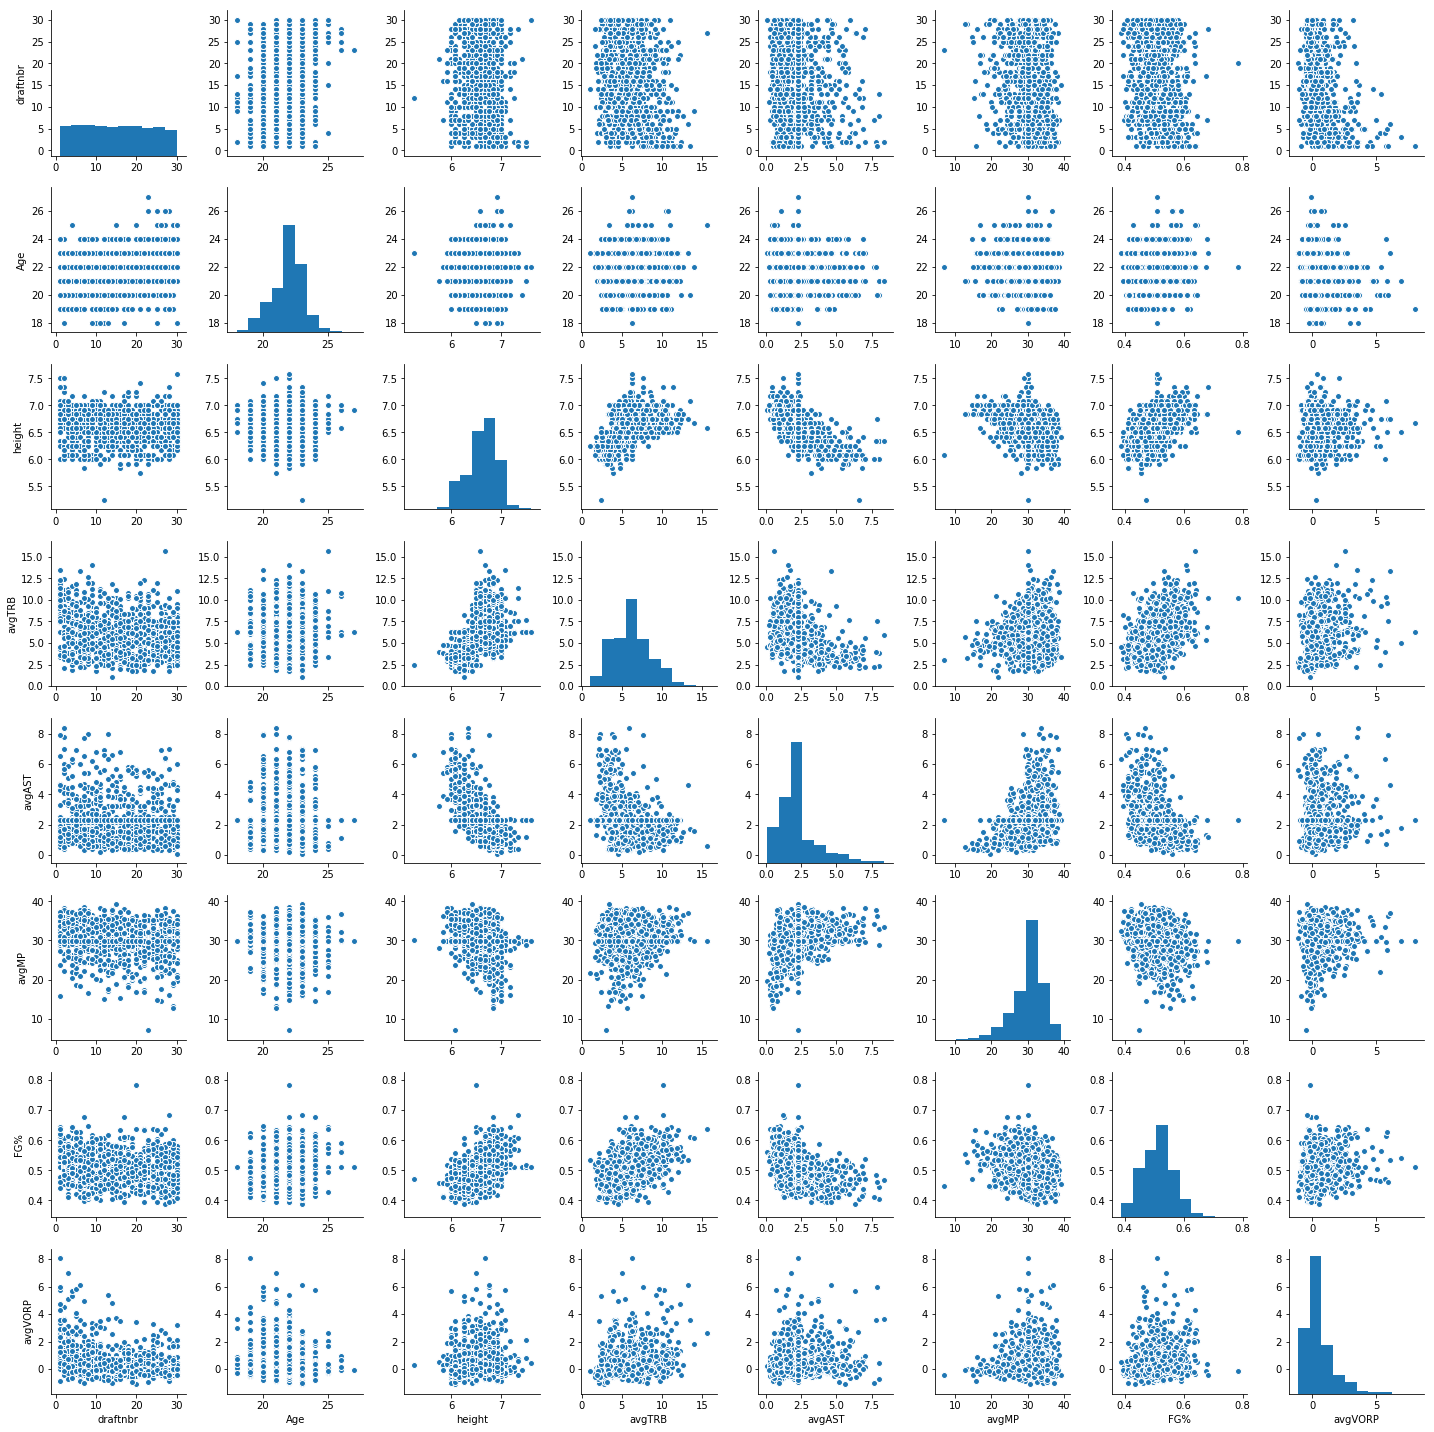

In [537]:
sns.pairplot(modeldata[['draftnbr','Age','height','avgTRB','avgAST','avgMP','FG%','avgVORP']]);

## 3.4 Saving Data For Model Tuning and Graphing

In [527]:
modeldata.to_pickle('data/modeldata.pkl')

In [531]:
playerdatafull.to_pickle('data/playerdatafull')
advstatsdf.to_pickle('data/advstats')